## Analysing difference of Grid cell activation as a function of distance

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import string

In [5]:
s = 0.2
N = 50
R = 50
num_points = 100

### Basic plots

In [6]:
def Lattice(l=1,l0=[0,0],t0=0,N=3):
    '''Return an array of x coordinates and y coordinates that create a hexagonal lattice
      of N^2 points of length l, rotated by theta t0 and displaced by l0  '''
    mlist = np.linspace(-N,N,2*N+1)
    nlist = np.linspace(-N,N,2*N+1)
    m,n = np.meshgrid(mlist,nlist)
    a0 = np.array([(3**0.5)/2,1/2]) *l
    b0 = np.array([(3**0.5)/2,-1/2]) *l

    # apply rotation
    theta = np.radians(t0)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    a,b = R@a0 + l0[0], R@b0 + l0[1]
    X = a[0]*m + b[0]*n
    Y = a[1]*m + b[1]*n
    return X,Y

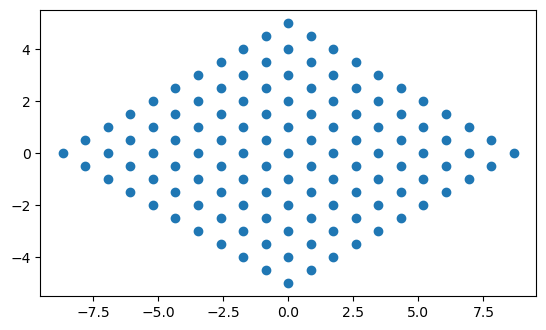

In [7]:
plt.scatter(*Lattice(l=1,t0=0,N=5))
# plt.set_aspect('equal', adjustable='box')
plt.axis('scaled')
plt.show()

The normal Gaussian is given by,
$$ \displaystyle g(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}\exp \left(-{\frac {1}{2}}{\frac {(x-\mu )^{2}}{\sigma ^{2}}}\right) $$

In [8]:
def GaussLattice(x,y,X,Y,s=1):
    ''' A function with periodic Gaussians centered at X,Y lattice'''
    exponent = (np.subtract.outer(X,x))**2  + (np.subtract.outer(Y,y))**2
    # print(exponent.shape)
    explat = np.exp(exponent / (-2*(s**2)))     # lattice of exponentials
    return np.sum(explat, axis=(0,1))

In [9]:
# s = 0.2
X1,Y1 = Lattice(l=1,t0=40,N=10)
X2,Y2 = Lattice(l=1,t0=42,N=10)
X3,Y3 = Lattice(l=1,t0=100,N=10)
# print(X.shape,Y.shape)
xyrange = np.linspace(-5,5,num_points)
x,y = np.meshgrid(xyrange,xyrange)
Z1 = GaussLattice(x,y,X1,Y1,s=s)
Z2 = GaussLattice(x,y,X2,Y2,s=s)
Z3 = GaussLattice(x,y,X3,Y3,s=s)

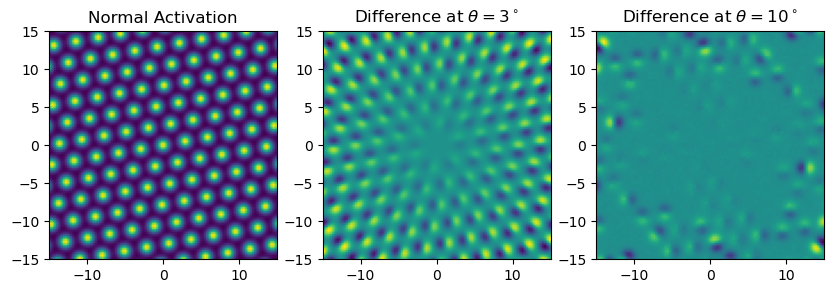

In [10]:
fig, ax = plt.subplots(1,3, figsize=(10,30))

ax[0].imshow(Z1,origin='lower',extent=[-15,15,-15,15])
ax[0].set_title("Normal Activation")

ax[1].imshow(Z2-Z1,origin='lower',extent=[-15,15,-15,15])
ax[1].set_title(r"Difference at $\theta=3^\circ$")

ax[2].imshow(Z3-Z1,origin='lower',extent=[-15,15,-15,15])
ax[2].set_title(r"Difference at $\theta=10^\circ$")

plt.show()

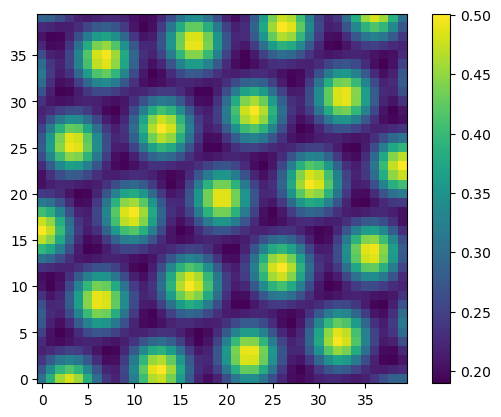

In [11]:
plt1 = sp.ndimage.gaussian_filter(Z1,sigma=2)
lower_limit = int(0.3*num_points)
upper_limit = int(0.7*num_points)
# plt.imshow(Z1[lower_limit:upper_limit,lower_limit:upper_limit])
# plt.matshow(plt1[lower_limit:upper_limit,lower_limit:upper_limit],vmin=0,vmax=0.3)
cax = plt.imshow(plt1[lower_limit:upper_limit,lower_limit:upper_limit], origin='lower')
fig.colorbar(cax)

In [12]:
# plt1.max()
plt1[lower_limit:upper_limit,lower_limit:upper_limit].min()

0.18967511959209035

### Gauss conv and 3d visualisation

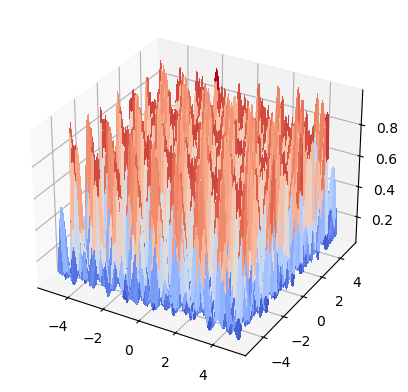

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x, y, Z1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

### Variation

In [14]:
def define_peak_variables(signal):
    ''' Define the peak of peaks and trough of troughs for further range calculation'''
    peaklocs, _ = sp.signal.find_peaks(signal)
    peaklocs2, _ = sp.signal.find_peaks(signal[peaklocs])
    troughlocs, _ = sp.signal.find_peaks(-signal)
    troughlocs2, _ = sp.signal.find_peaks(-signal[troughlocs])
    return peaklocs, peaklocs2, troughlocs, troughlocs2

In [15]:
def show_theta_var(t=0,dt=0,ax=0, conv=False, verbose=True):
    '''Plots the variation of grid response along the theta=t angle when 
    the grids have a difference in theta of dt'''
    r = np.linspace(-R,R,num_points)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1,t0=-dt,N=N)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)
    signal = Z2-Z1
    peaklocs, peaklocs2, troughlocs, troughlocs2 = define_peak_variables(signal)

    if conv:
        signal_conv = sp.ndimage.gaussian_filter(signal,sigma=8)
        if ax!=0:
            ax.plot(r,signal_conv)
            ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$at $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
        else:
            plt.plot(r,signal_conv)
            plt.title(r"Smooth Diff of activity along $\theta=$" +f"{t}" +r"$^\circ$at $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
        return r[peaklocs][peaklocs2], r[troughlocs][troughlocs2]

    if verbose:
        print(f"\n For {t} and {dt} Monotonicity of peaks break at {r[peaklocs][peaklocs2]}")
        print(f"Monotonicity of troughs break at {r[troughlocs][troughlocs2]} \n")

    if ax!=0:
        ax.plot(r,signal)
        ax.scatter(r[peaklocs][peaklocs2], signal[peaklocs][peaklocs2], color='r')
        ax.scatter(r[troughlocs][troughlocs2], signal[troughlocs][troughlocs2], color='g')
        ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    else:
        plt.plot(r,signal)
        plt.scatter(r[peaklocs][peaklocs2], signal[peaklocs][peaklocs2], color='r')
        plt.scatter(r[troughlocs][troughlocs2], signal[troughlocs][troughlocs2], color='g')
        plt.title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$ \n")
    return r[peaklocs][peaklocs2], r[troughlocs][troughlocs2]

def show_dist_var(t=0,dl=0,ax=0, conv=False, verbose=True):
    '''Plots the variation of grid response along the theta=t angle when 
    the grids have a difference in lambda of dl'''
    r = np.linspace(-R,R,num_points)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1+dl,t0=0,N=N)
    # X3,Y3 = Lattice(l=1,t0=10,N=10)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)
    signal = Z2-Z1
    peaklocs, peaklocs2, troughlocs, troughlocs2 = define_peak_variables(signal)

    if conv:
        signal_conv = sp.ndimage.gaussian_filter(signal,sigma=8)
        if ax!=0:
            ax.plot(r,signal_conv)
            ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$at $\Delta \lambda=$" +f"{dl}" +r"$^\circ$")
        else:
            plt.plot(r,signal_conv)
            plt.title(r"Smooth Diff of activity along $\theta=$" +f"{t}" +r"$^\circ$at $\Delta \lambda=$" +f"{dl}" +r"$^\circ$")
        return r[peaklocs][peaklocs2], r[troughlocs][troughlocs2]

    if verbose:
        print(f"\n For {t} and {dl} Monotonicity of peaks break at {r[peaklocs][peaklocs2]}")
        print(f"Monotonicity of troughs break at {r[troughlocs][troughlocs2]} \n")

    if ax!=0:
        ax.plot(r,signal)
        ax.scatter(r[peaklocs][peaklocs2], signal[peaklocs][peaklocs2], color='r')
        ax.scatter(r[troughlocs][troughlocs2], signal[troughlocs][troughlocs2], color='g')
        ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\lambda=$" +f"{dl}")
    else:
        plt.plot(r,signal)
        plt.scatter(r[peaklocs][peaklocs2], signal[peaklocs][peaklocs2], color='r')
        plt.scatter(r[troughlocs][troughlocs2], signal[troughlocs][troughlocs2], color='g')
        plt.title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\lambda=$" +f"{dl}")
    return r[peaklocs][peaklocs2], r[troughlocs][troughlocs2]



 For 90 and 10 Monotonicity of peaks break at [-34.84848485 -24.74747475 -14.64646465  -4.54545455   4.54545455
  14.64646465  24.74747475  34.84848485]
Monotonicity of troughs break at [] 


 For 90 and 3 Monotonicity of peaks break at [-15.65656566  15.65656566]
Monotonicity of troughs break at [] 



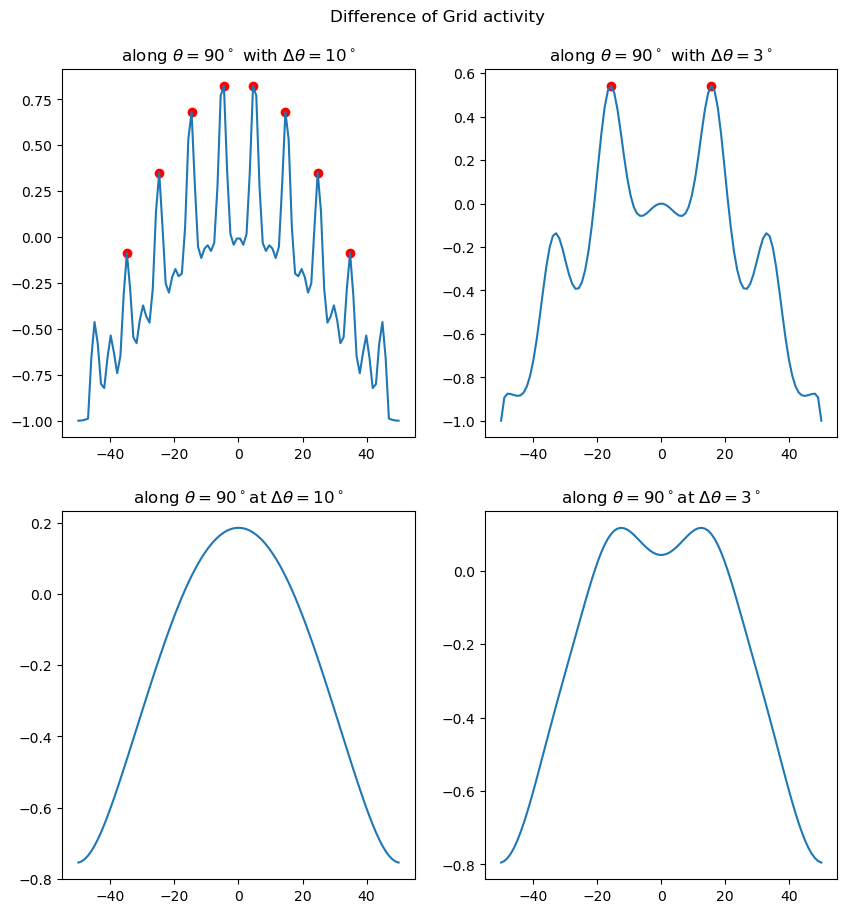

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.suptitle("Difference of Grid activity")
fig.tight_layout = True
fig.subplots_adjust(top=0.92)

angle = 90
show_theta_var(angle,10, ax[0,0])
show_theta_var(angle,3, ax[0,1])
show_theta_var(angle,10, ax[1,0], conv=True)
show_theta_var(angle,3, ax[1,1], conv=True)
plt.show()


 For 90 and 0.3 Monotonicity of peaks break at [-42.92929293   2.52525253  42.92929293]
Monotonicity of troughs break at [] 


 For 90 and 0.03 Monotonicity of peaks break at []
Monotonicity of troughs break at [] 



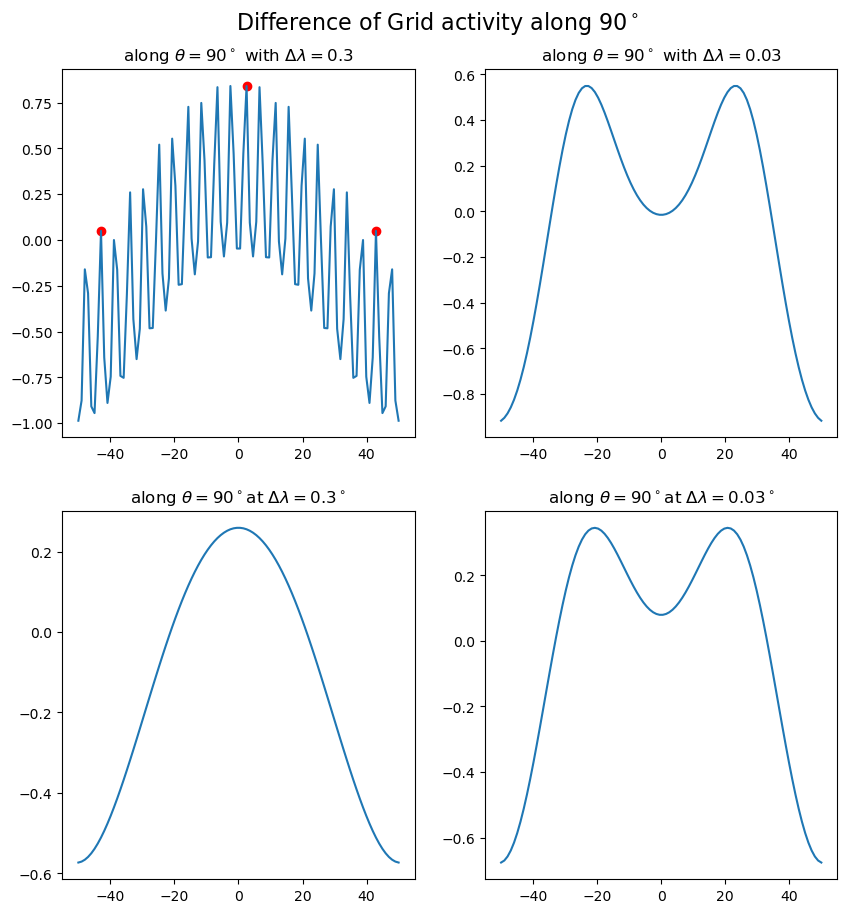

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.suptitle(f"Difference of Grid activity along {angle}"+r"$^\circ$", size=16)
fig.tight_layout = True
fig.subplots_adjust(top=0.92)

show_dist_var(angle,0.3, ax[0,0])
show_dist_var(angle,0.03, ax[0,1])
show_dist_var(angle,0.3, ax[1,0], conv=True)
show_dist_var(angle,0.03, ax[1,1], conv= True)
plt.show()

### Full page comparison plots

In [20]:
def plot_theta(angle, figlabel):
    fig, ax = plt.subplots(2, 4, figsize=(20,10), sharey=True)
    plt.suptitle(f"Difference of Grid activity along {angle}"+r"$^\circ$", size=16)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.92)

    dts = [2,4,6,8,-2,-4,-6,-8]
    labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    for i, axis in enumerate(ax.flatten()):
        show_theta_var(angle, dts[i], axis)
        # axis.annotate(labels[i], xy=(0,1))
        axis.text(-0.02, 1.03, figlabel+str(i+1) , transform=axis.transAxes, size=20, weight='bold')
        # axis.text(-0.02, 1.02, string.ascii_uppercase[i], transform=axis.transAxes, size=20, weight='bold')

    # show_theta_var(angle,2, ax[0,0])
    # show_theta_var(angle,4, ax[0,1])
    # show_theta_var(angle,6, ax[0,2])
    # show_theta_var(angle,8, ax[0,3])

    # show_theta_var(angle,-2, ax[1,0])
    # show_theta_var(angle,-4, ax[1,1])
    # show_theta_var(angle,-6, ax[1,2])
    # show_theta_var(angle,-8, ax[1,3])

    plt.show()

def plot_theta_conv(angle, figlabel):
    fig, ax = plt.subplots(2, 4, figsize=(20,10), sharey=True)
    plt.suptitle(f"Smoothed (Gaussian convolved) difference of Grid activity along {angle}"+r"$^\circ$", size=16)
    fig.tight_layout = True
    fig.subplots_adjust(top=0.92)

    dts = [2,4,6,8,-2,-4,-6,-8]
    labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    for i, axis in enumerate(ax.flatten()):
        show_theta_var(angle, dts[i], axis, conv=True)
        # axis.annotate(labels[i], xy=(0,1))
        axis.text(-0.02, 1.03, figlabel+str(i+1) , transform=axis.transAxes, size=20, weight='bold')
        # axis.text(-0.02, 1.02, string.ascii_uppercase[i], transform=axis.transAxes, size=20, weight='bold')

    # show_theta_var(angle,2, ax[0,0])
    # show_theta_var(angle,4, ax[0,1])
    # show_theta_var(angle,6, ax[0,2])
    # show_theta_var(angle,8, ax[0,3])

    # show_theta_var(angle,-2, ax[1,0])
    # show_theta_var(angle,-4, ax[1,1])
    # show_theta_var(angle,-6, ax[1,2])
    # show_theta_var(angle,-8, ax[1,3])

    plt.show()


 For 88 and 2 Monotonicity of peaks break at []
Monotonicity of troughs break at [-21.71717172  21.71717172] 


 For 88 and 4 Monotonicity of peaks break at [-29.7979798   -5.55555556   5.55555556  29.7979798 ]
Monotonicity of troughs break at [-44.94949495 -19.6969697    4.54545455  19.6969697   44.94949495] 


 For 88 and 6 Monotonicity of peaks break at [-36.86868687 -11.61616162  11.61616162  36.86868687]
Monotonicity of troughs break at [-20.70707071  20.70707071] 


 For 88 and 8 Monotonicity of peaks break at [-8.58585859  8.58585859]
Monotonicity of troughs break at [-20.70707071  20.70707071] 


 For 88 and -2 Monotonicity of peaks break at [-36.86868687 -11.61616162  11.61616162  36.86868687]
Monotonicity of troughs break at [-20.70707071  20.70707071] 


 For 88 and -4 Monotonicity of peaks break at [-8.58585859  8.58585859]
Monotonicity of troughs break at [-20.70707071  20.70707071] 


 For 88 and -6 Monotonicity of peaks break at [-30.80808081  -6.56565657   6.56565657  

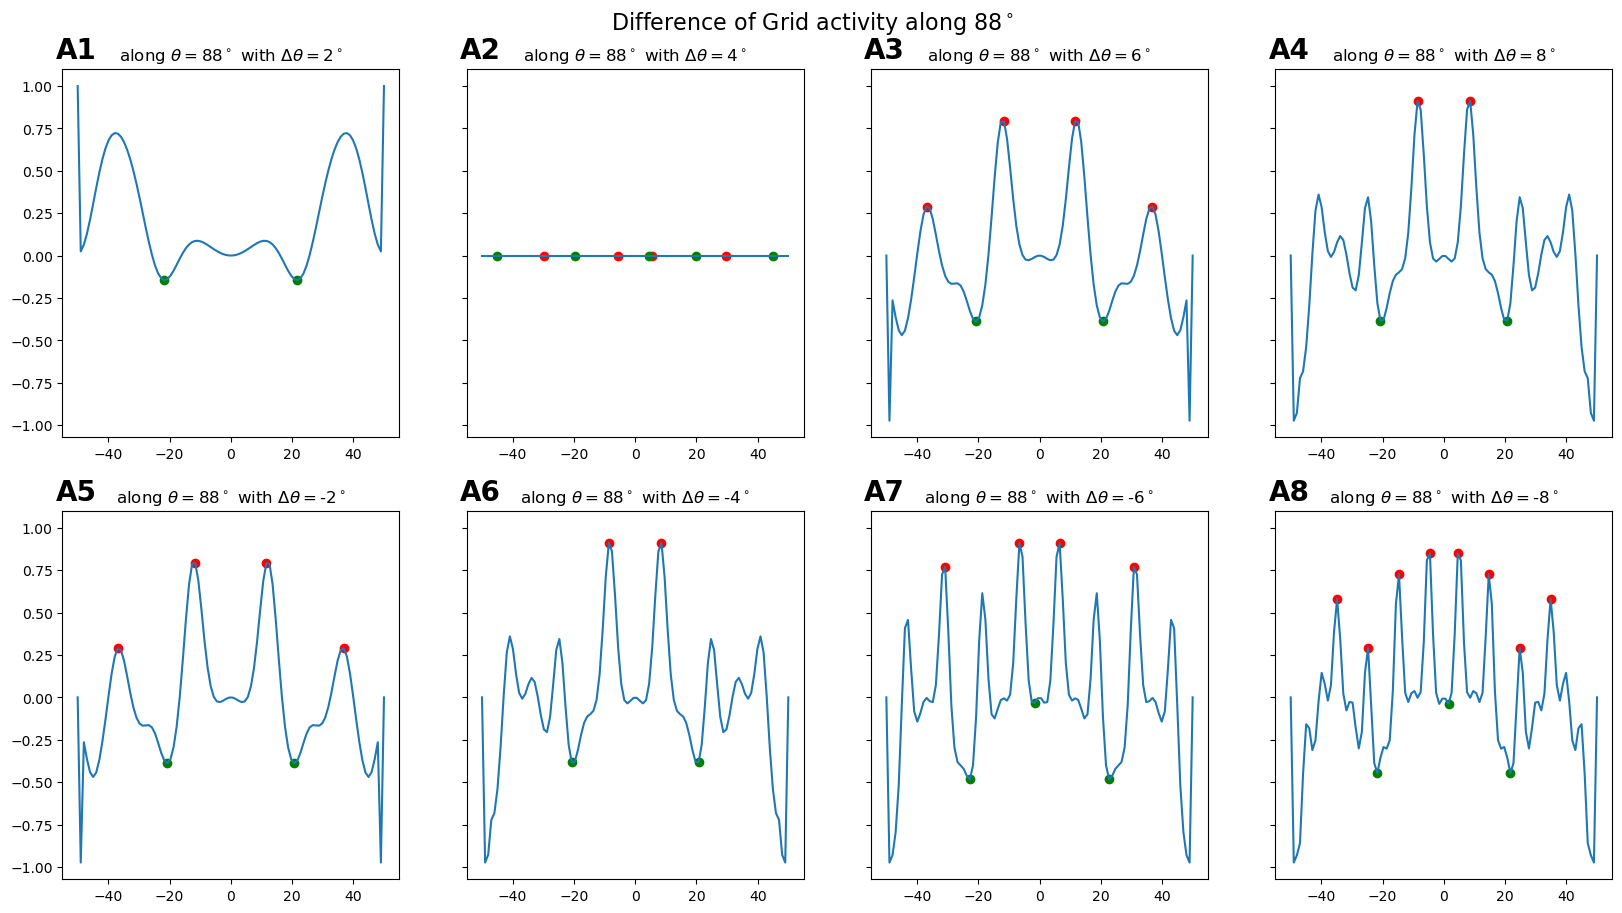

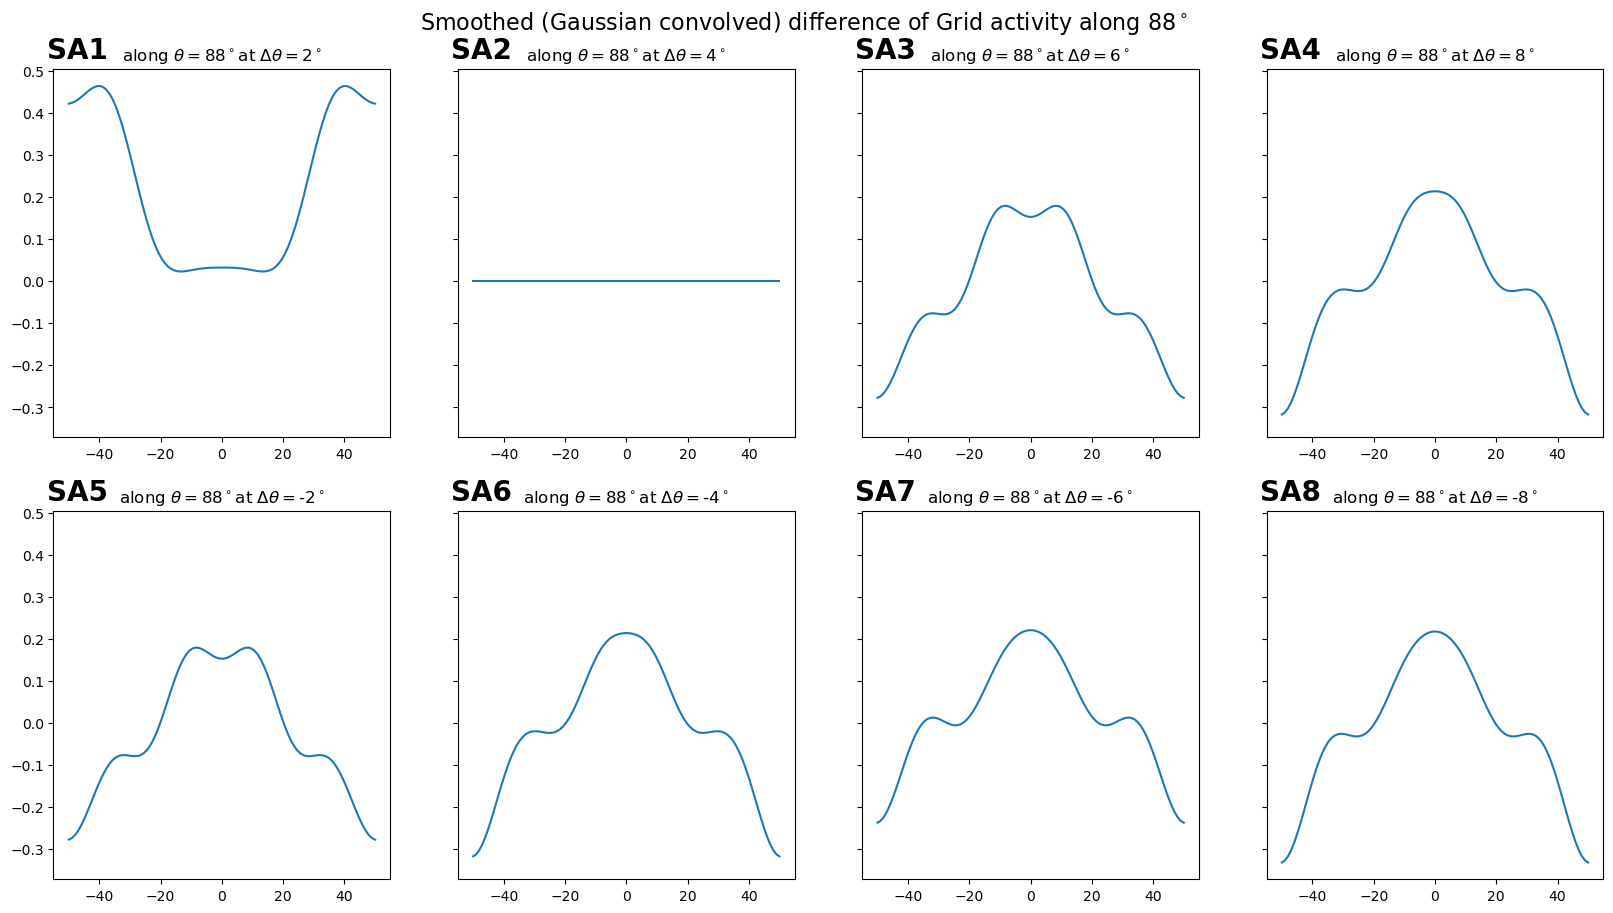


 For 90 and 2 Monotonicity of peaks break at [-21.71717172  21.71717172]
Monotonicity of troughs break at [] 


 For 90 and 4 Monotonicity of peaks break at [-12.62626263  12.62626263]
Monotonicity of troughs break at [] 


 For 90 and 6 Monotonicity of peaks break at [-40.90909091 -24.74747475  -8.58585859   8.58585859  24.74747475
  40.90909091]
Monotonicity of troughs break at [] 


 For 90 and 8 Monotonicity of peaks break at [-18.68686869  -6.56565657   6.56565657  18.68686869]
Monotonicity of troughs break at [] 


 For 90 and -2 Monotonicity of peaks break at [-21.71717172  21.71717172]
Monotonicity of troughs break at [] 


 For 90 and -4 Monotonicity of peaks break at [-12.62626263  12.62626263]
Monotonicity of troughs break at [] 


 For 90 and -6 Monotonicity of peaks break at [-40.90909091 -24.74747475  -8.58585859   8.58585859  24.74747475
  40.90909091]
Monotonicity of troughs break at [] 


 For 90 and -8 Monotonicity of peaks break at [-18.68686869  -6.56565657   6.565

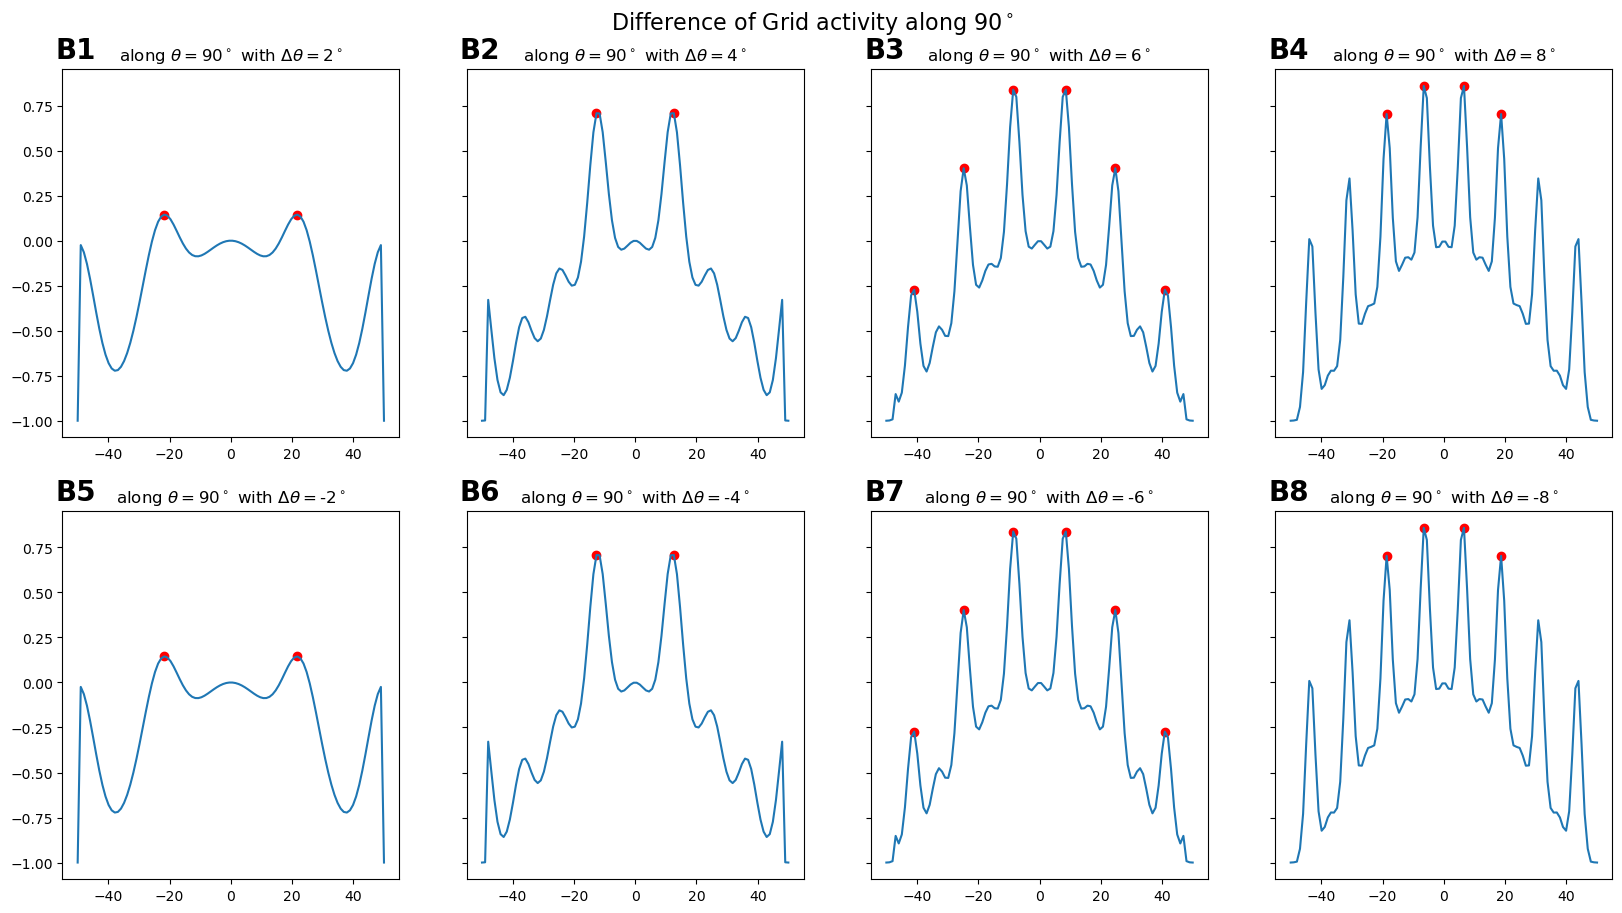

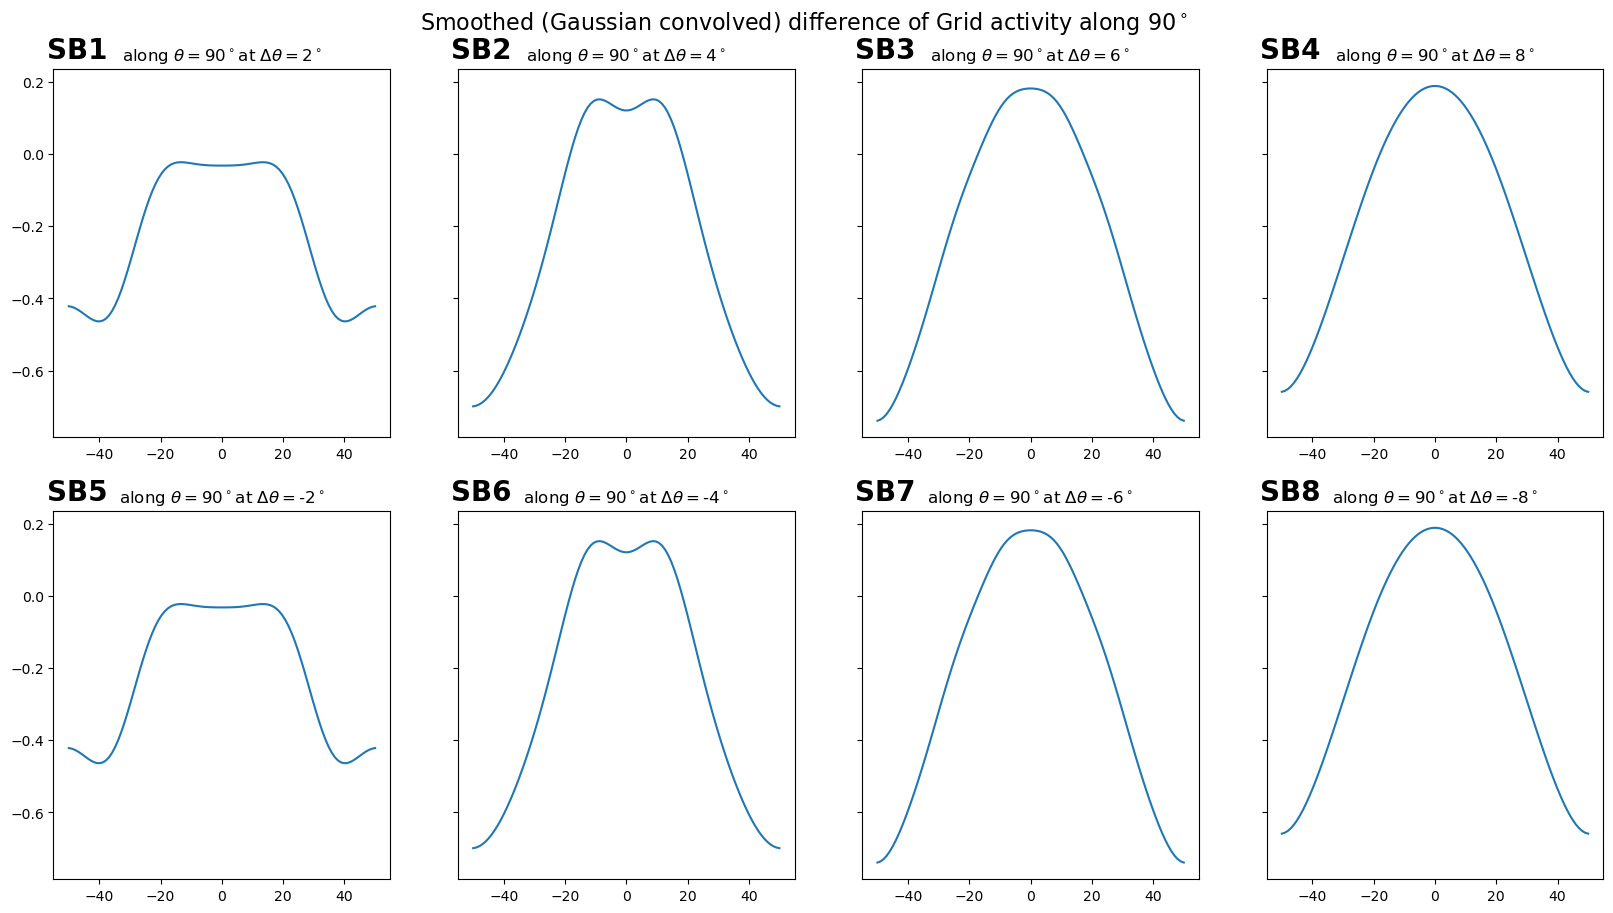


 For 92 and 2 Monotonicity of peaks break at [-36.86868687 -11.61616162  11.61616162  36.86868687]
Monotonicity of troughs break at [-20.70707071  20.70707071] 


 For 92 and 4 Monotonicity of peaks break at [-8.58585859  8.58585859]
Monotonicity of troughs break at [-20.70707071  20.70707071] 


 For 92 and 6 Monotonicity of peaks break at [-30.80808081  -6.56565657   6.56565657  30.80808081]
Monotonicity of troughs break at [-22.72727273   1.51515152  22.72727273] 


 For 92 and 8 Monotonicity of peaks break at [-34.84848485 -24.74747475 -14.64646465  -4.54545455   4.54545455
  14.64646465  24.74747475  34.84848485]
Monotonicity of troughs break at [-21.71717172   1.51515152  21.71717172] 


 For 92 and -2 Monotonicity of peaks break at []
Monotonicity of troughs break at [-21.71717172  21.71717172] 


 For 92 and -4 Monotonicity of peaks break at [-43.93939394 -32.82828283 -23.73737374 -16.66666667  -5.55555556
   5.55555556  16.66666667  23.73737374  32.82828283  43.93939394]
Mono

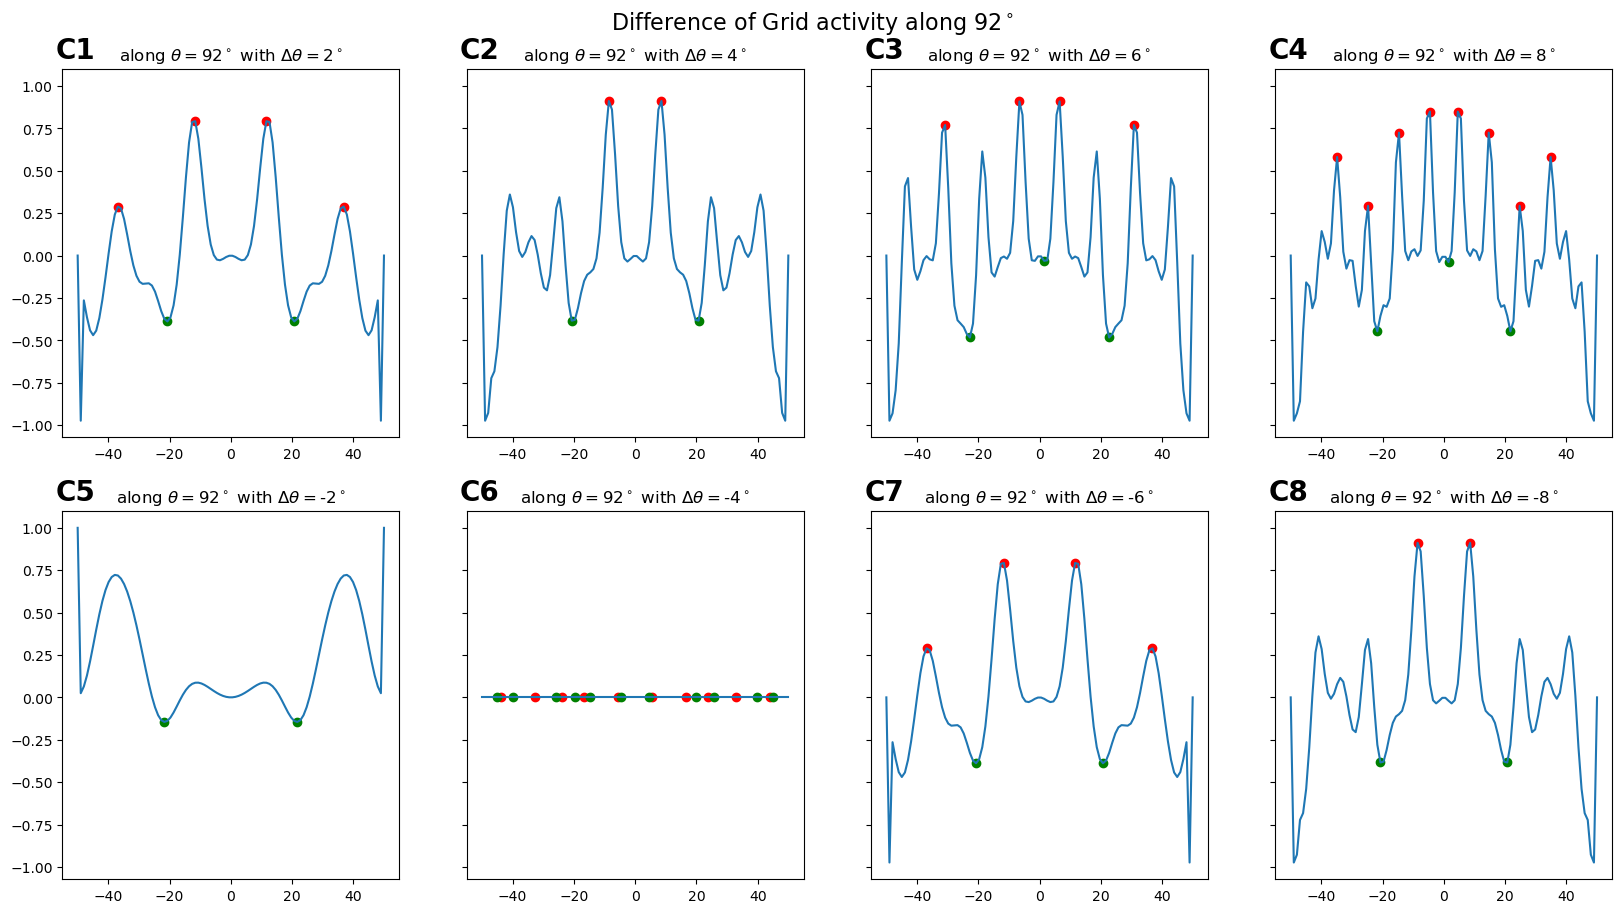

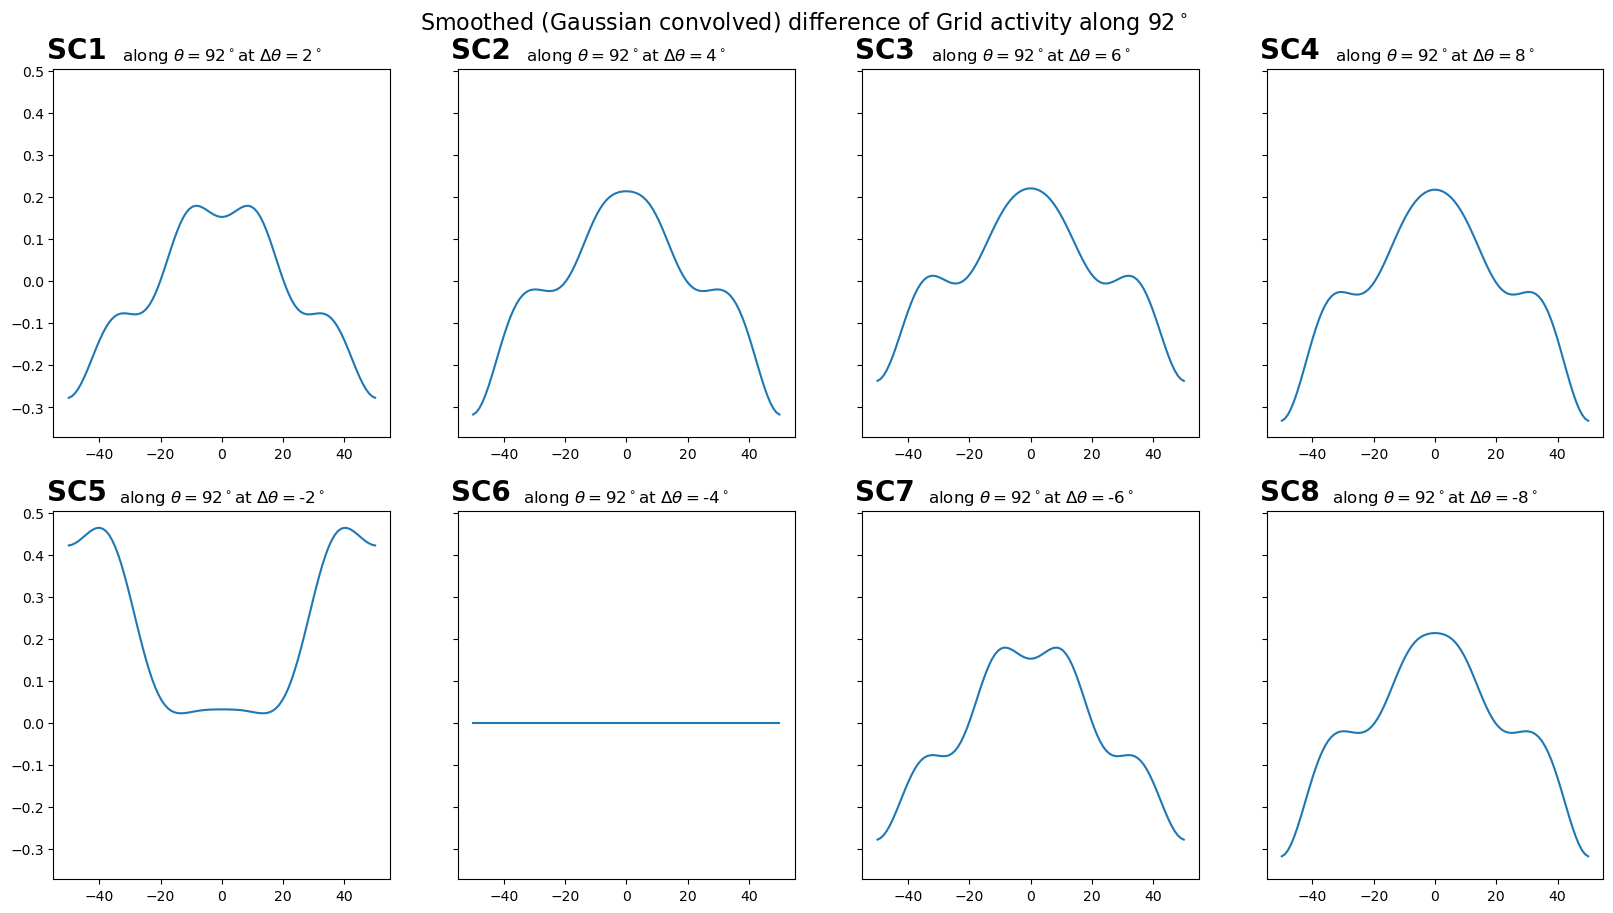

In [21]:
plot_theta(88, 'A')
plot_theta_conv(88, 'SA')
plot_theta(90, 'B')
plot_theta_conv(90, 'SB')
plot_theta(92, 'C')
plot_theta_conv(92, 'SC')


 For 58 and 2 Monotonicity of peaks break at [-41.45728643 -36.4321608  -20.85427136 -17.33668342 -13.81909548
 -10.30150754  10.30150754  13.81909548  17.33668342  20.85427136
  36.4321608   41.45728643]
Monotonicity of troughs break at [-42.46231156 -38.94472362 -27.88944724 -14.8241206  -11.30653266
  -7.78894472   7.78894472  11.30653266  14.8241206   27.88944724
  38.94472362  42.46231156] 


 For 58 and 4 Monotonicity of peaks break at [-40.45226131 -34.42211055 -30.90452261 -23.36683417 -17.83919598
 -14.32160804  -6.7839196    3.26633166   6.7839196   10.30150754
  14.32160804  19.84924623  23.36683417  27.38693467  30.90452261
  34.42211055  40.45226131]
Monotonicity of troughs break at [-40.95477387 -37.43718593 -29.89949749 -27.88944724 -24.3718593
 -17.33668342 -14.8241206  -11.30653266  -7.78894472   0.75376884
   4.27135678   7.78894472  11.30653266  14.8241206   18.34170854
  22.36180905  27.88944724  29.89949749  37.43718593  40.95477387] 


 For 58 and 6 Monotonicity 

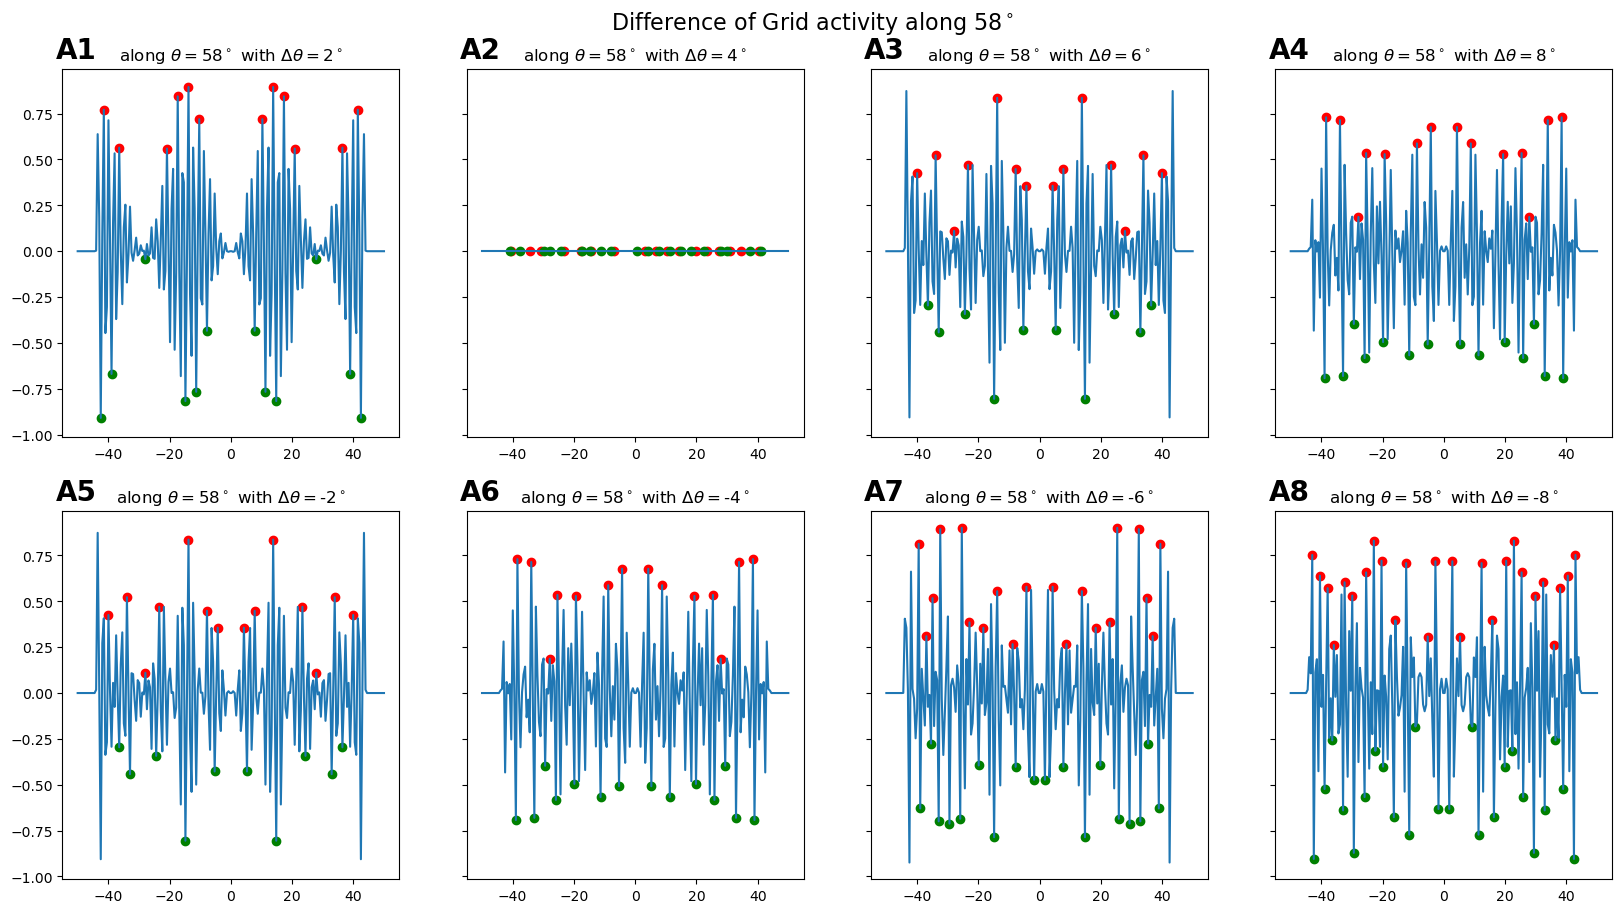

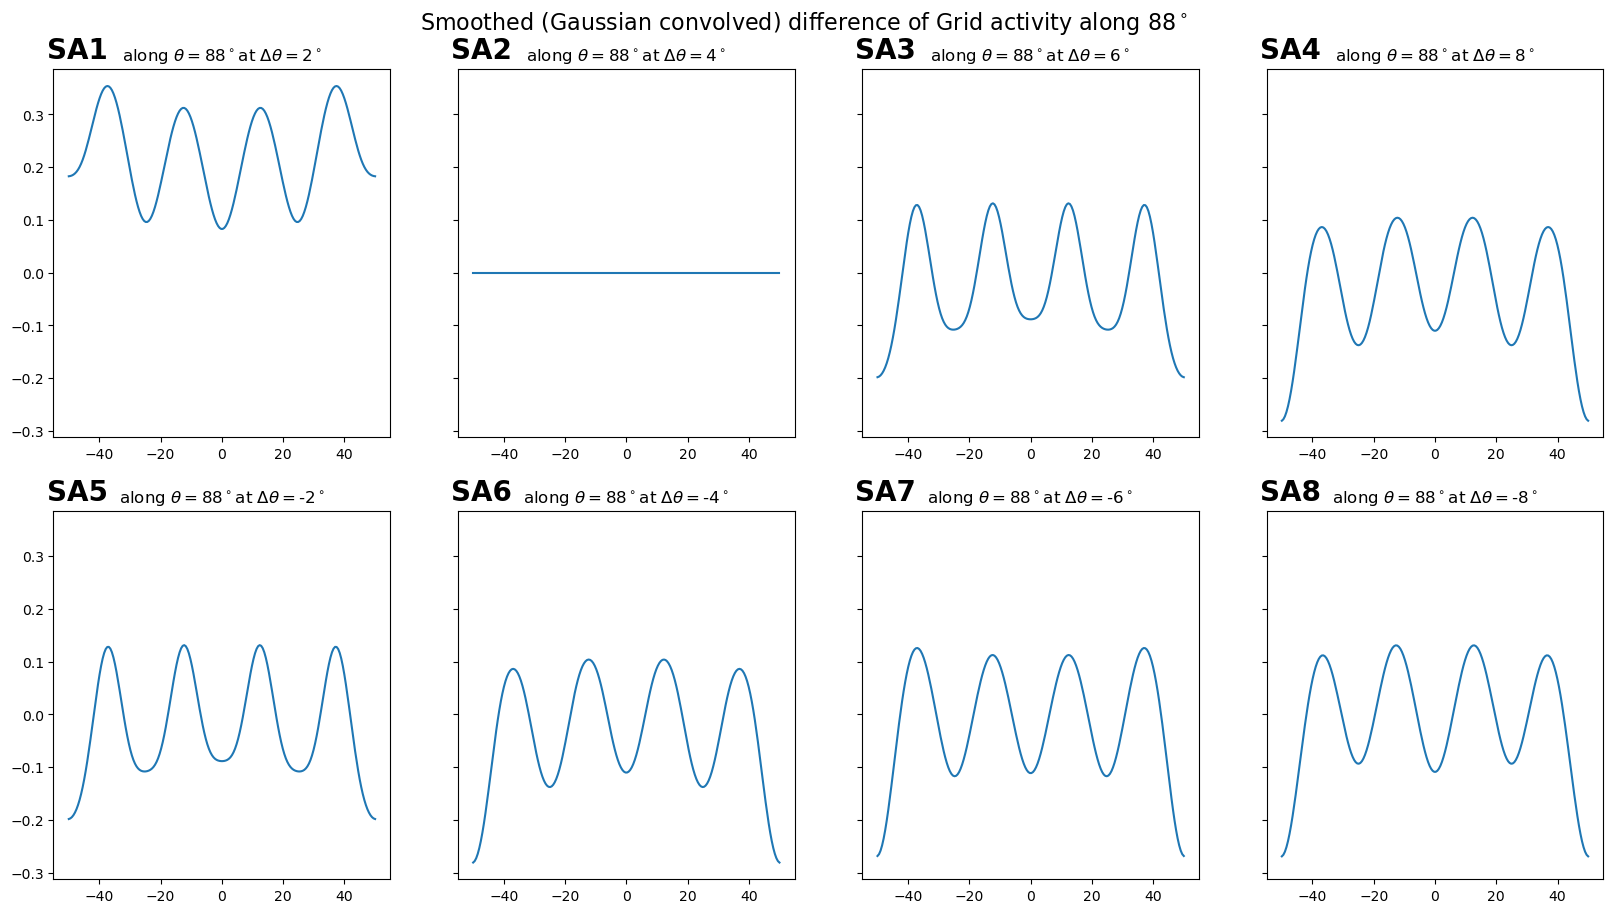


 For 60 and 2 Monotonicity of peaks break at [-42.46231156 -38.94472362 -27.88944724 -14.8241206  -11.30653266
  -7.78894472   7.78894472  11.30653266  14.8241206   27.88944724
  38.94472362  42.46231156]
Monotonicity of troughs break at [-41.45728643 -36.4321608  -20.85427136 -17.33668342 -13.81909548
 -10.30150754  10.30150754  13.81909548  17.33668342  20.85427136
  36.4321608   41.45728643] 


 For 60 and 4 Monotonicity of peaks break at [-37.43718593 -33.91959799 -27.88944724 -21.85929648  -7.78894472
   7.78894472  21.85929648  27.88944724  33.91959799  37.43718593]
Monotonicity of troughs break at [-41.45728643 -36.4321608  -32.91457286 -20.85427136  -5.27638191
   5.27638191  20.85427136  32.91457286  36.4321608   41.45728643] 


 For 60 and 6 Monotonicity of peaks break at [-38.44221106 -33.91959799 -27.88944724 -23.36683417 -14.8241206
  -4.27135678   4.27135678  14.8241206   23.36683417  27.88944724
  33.91959799  38.44221106]
Monotonicity of troughs break at [-41.45728643 

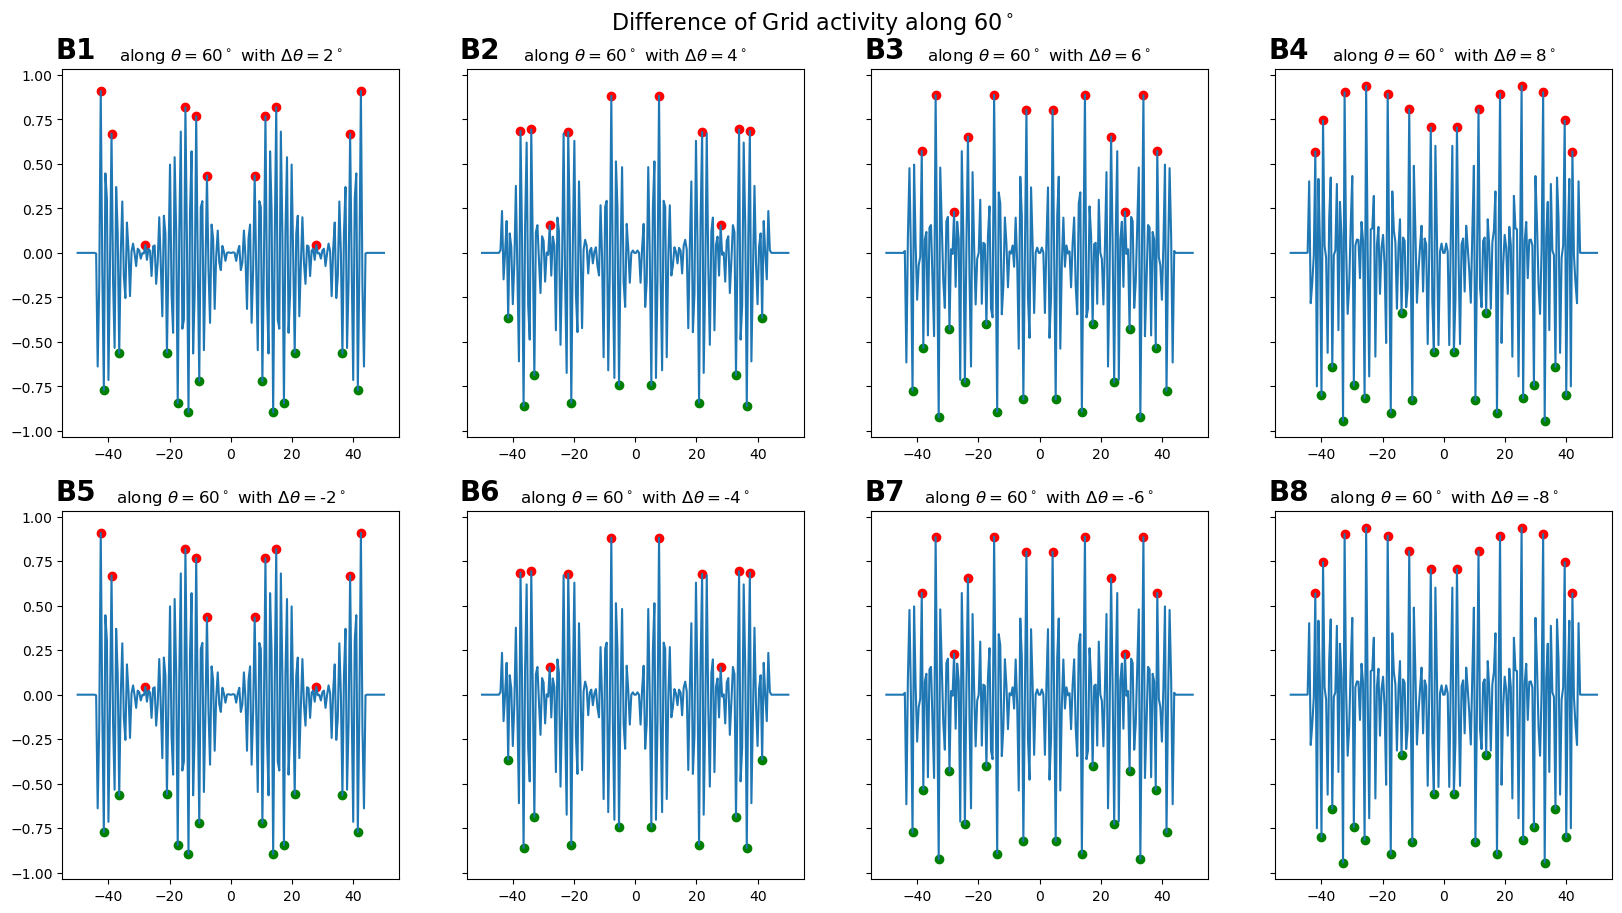

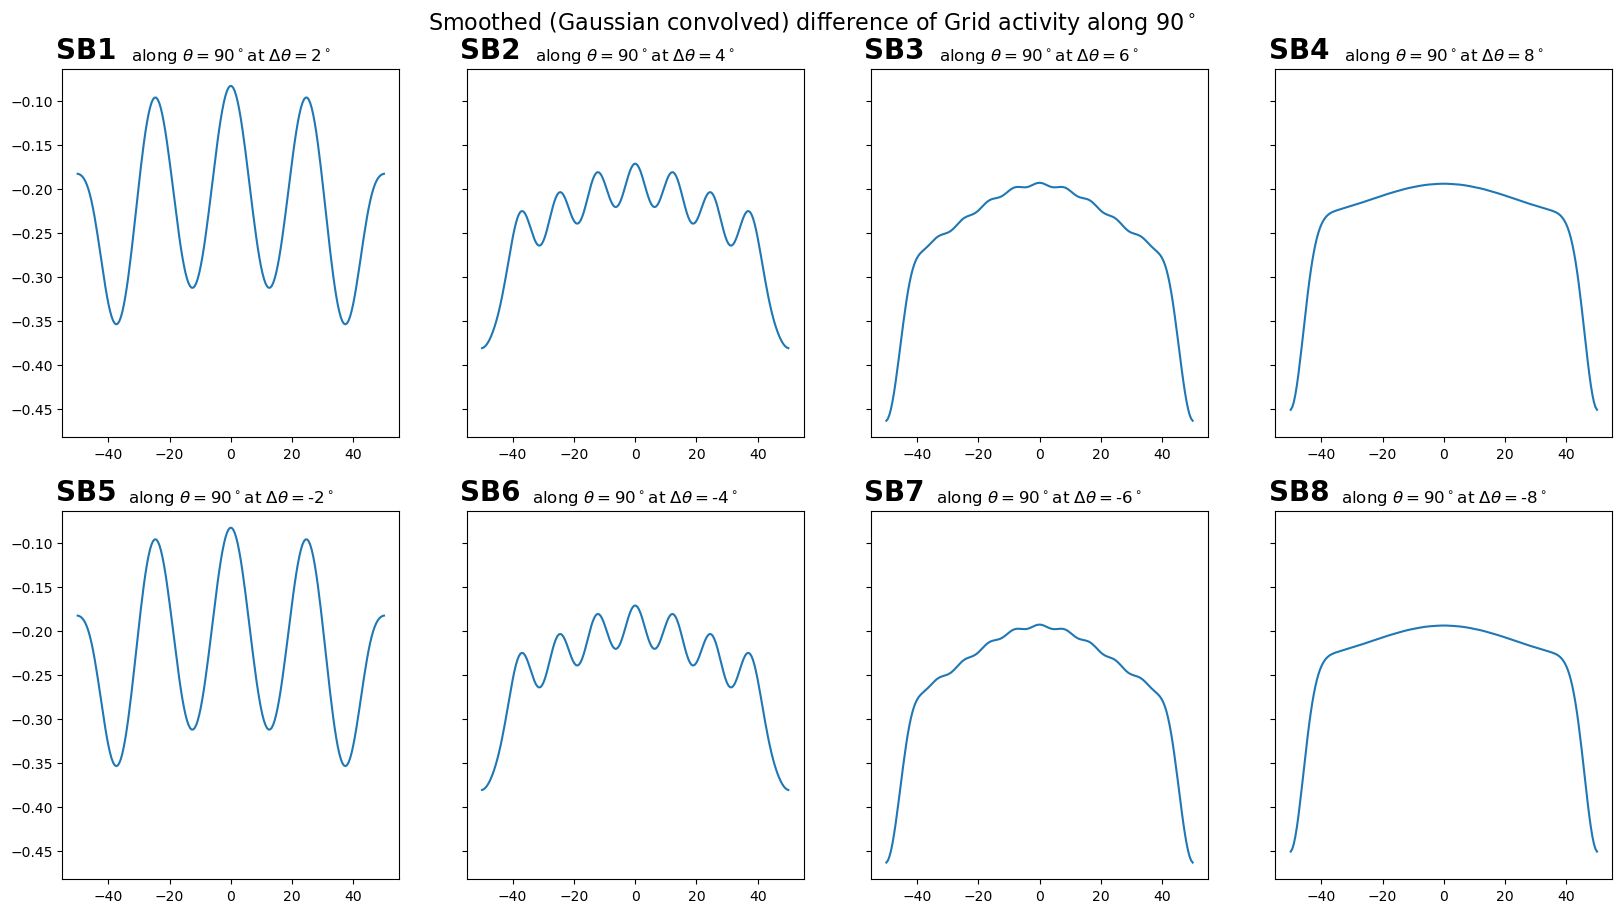


 For 62 and 2 Monotonicity of peaks break at [-39.94974874 -33.91959799 -27.88944724 -23.36683417 -13.81909548
  -7.78894472  -4.27135678   4.27135678   7.78894472  13.81909548
  23.36683417  27.88944724  33.91959799  39.94974874]
Monotonicity of troughs break at [-36.4321608  -32.91457286 -24.3718593  -14.8241206   -5.27638191
   5.27638191  14.8241206   24.3718593   32.91457286  36.4321608 ] 


 For 62 and 4 Monotonicity of peaks break at [-38.44221106 -33.91959799 -27.88944724 -25.37688442 -19.34673367
  -8.79396985  -4.27135678   4.27135678   8.79396985  19.34673367
  25.37688442  27.88944724  33.91959799  38.44221106]
Monotonicity of troughs break at [-38.94472362 -32.91457286 -29.39698492 -25.87939698 -19.84924623
 -11.30653266  -5.27638191   5.27638191  11.30653266  19.84924623
  25.87939698  29.39698492  32.91457286  38.94472362] 


 For 62 and 6 Monotonicity of peaks break at [-39.44723618 -36.93467337 -34.92462312 -32.4120603  -25.37688442
 -22.86432161 -18.34170854 -13.8190

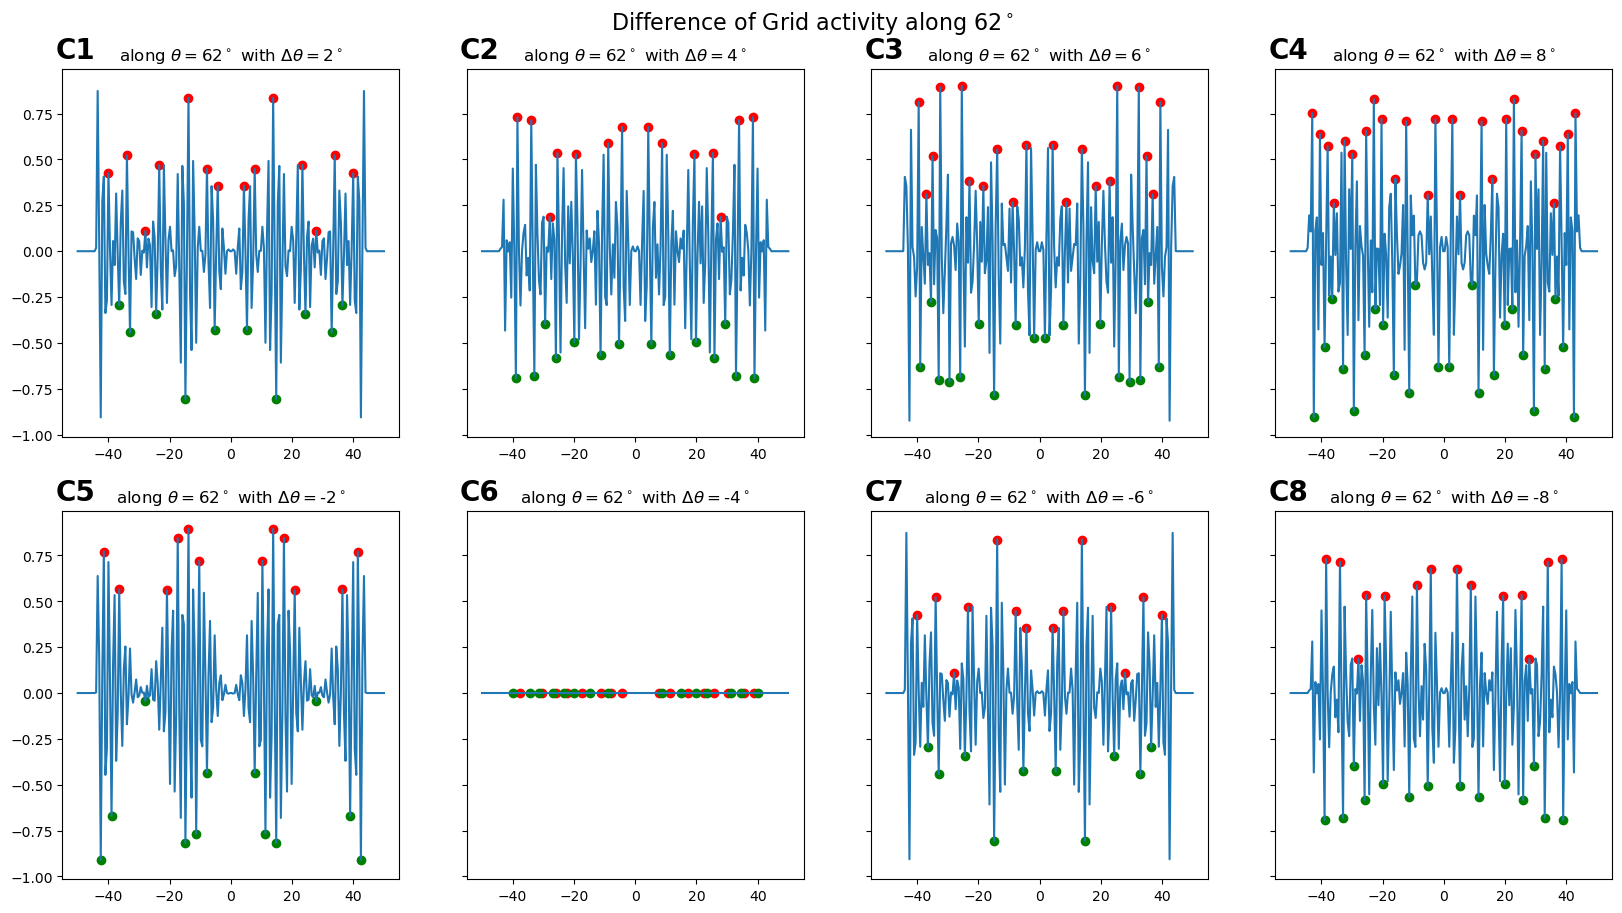

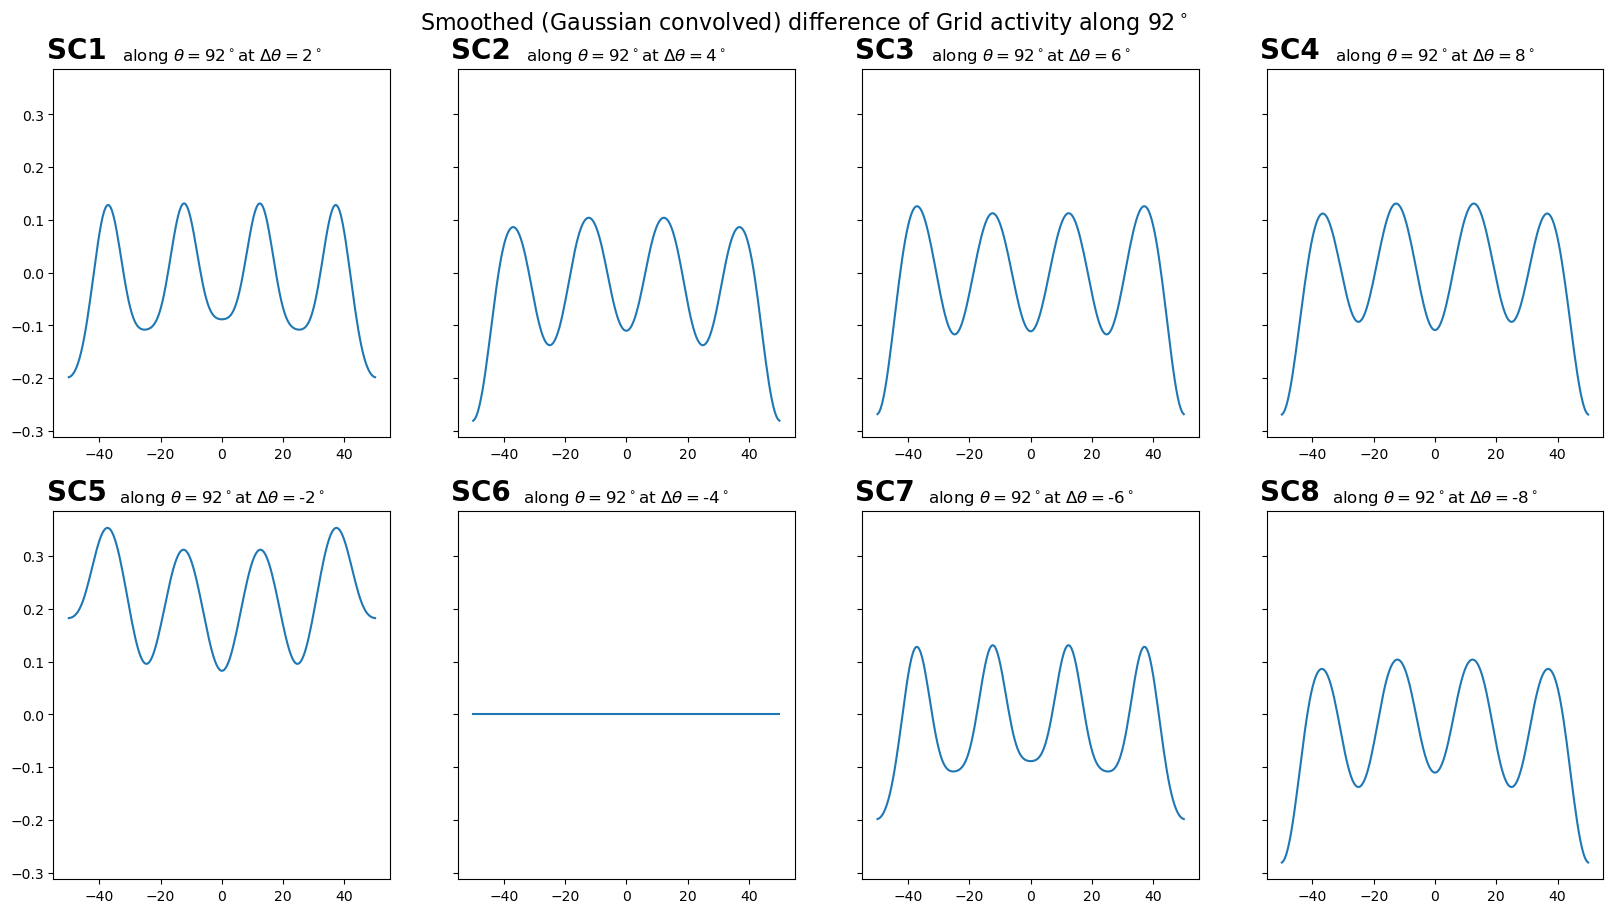

In [ ]:
plot_theta(58, 'A')
plot_theta_conv(88, 'SA')
plot_theta(60, 'B')
plot_theta_conv(90, 'SB')
plot_theta(62, 'C')
plot_theta_conv(92, 'SC')

### Animation (To-Do)

## Metric of monotonicity

### Simple uniform distance

In [ ]:
def monometric_theta(t=0, dt=0, ax=0):
    l = 1
    r = np.arange(-20,20,l)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1,t0=dt,N=N)
    # X3,Y3 = Lattice(l=1,t0=10,N=10)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)

    if ax!=0:
        ax.scatter(r,Z1-Z2)
        ax.set_title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    else:
        plt.scatter(r,Z1-Z2)
        plt.title(r"along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")

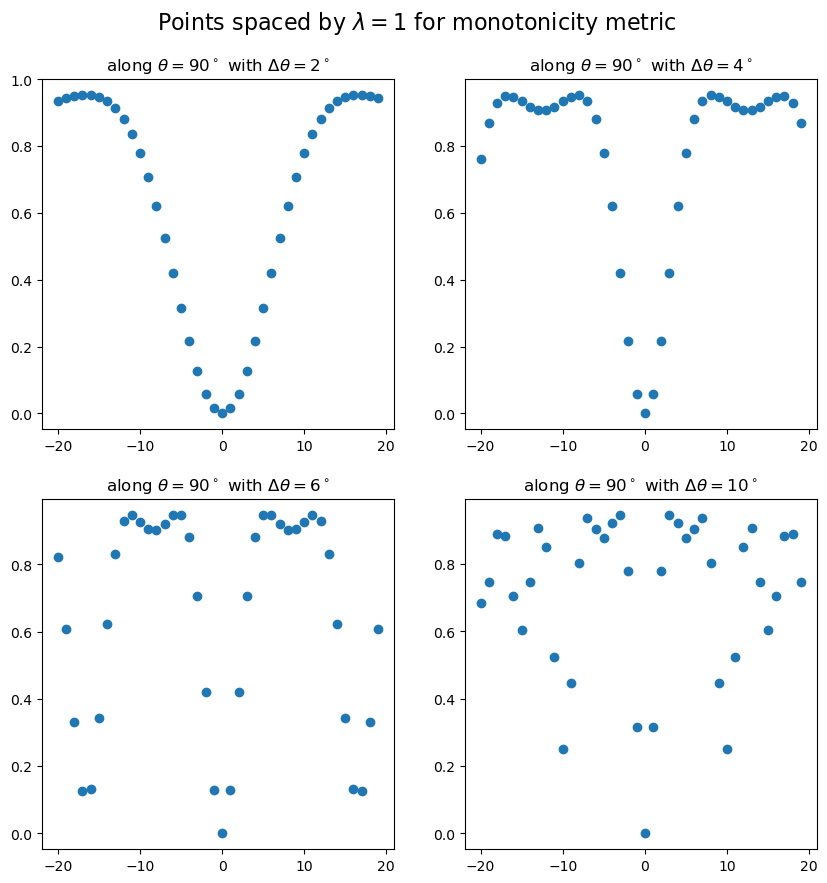

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.tight_layout = True
fig.suptitle(r"Points spaced by $\lambda=1$ for monotonicity metric", size=16, y=0.95)
fig.subplots_adjust(top=0.88)

monometric_theta(90, 2, ax[0,0]) 
monometric_theta(90, 4, ax[0,1]) 
monometric_theta(90, 6, ax[1,0]) 
monometric_theta(90, 10, ax[1,1]) 


 For 90 and 2 Monotonicity of peaks break at [-25.37688442   0.25125628  25.37688442]
Monotonicity of troughs break at [-34.92462312 -15.82914573  15.82914573  34.92462312] 


 For 90 and 4 Monotonicity of peaks break at [-48.49246231 -37.43718593 -25.37688442 -12.31155779  -0.25125628
  12.31155779  25.37688442  37.43718593  48.49246231]
Monotonicity of troughs break at [-42.96482412 -31.90954774 -18.84422111  -6.7839196    6.7839196
  18.84422111  31.90954774  42.96482412] 


 For 90 and 6 Monotonicity of peaks break at [-47.48743719 -41.45728643 -33.41708543 -25.37688442 -16.33165829
  -8.29145729  -0.25125628   8.29145729  16.33165829  25.37688442
  33.41708543  41.45728643  47.48743719]
Monotonicity of troughs break at [-45.9798995  -36.93467337 -28.89447236 -20.85427136 -12.81407035
  -4.77386935   4.77386935  12.81407035  20.85427136  28.89447236
  36.93467337  45.9798995 ] 


 For 90 and 10 Monotonicity of peaks break at [-45.47738693 -39.44723618 -35.42713568 -30.40201005 -24

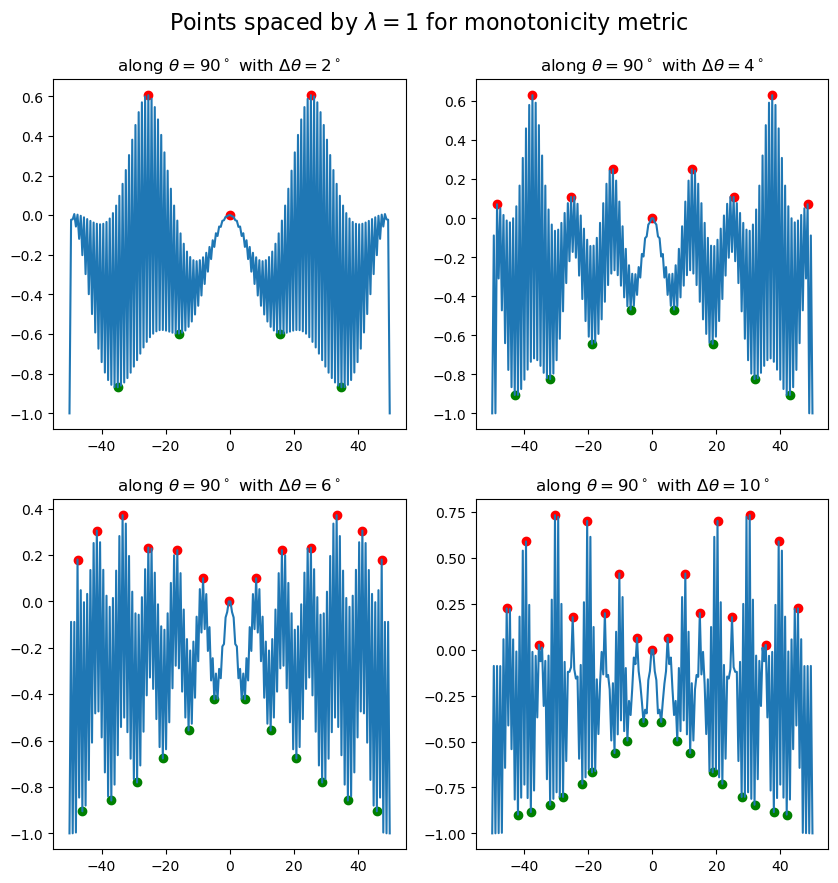

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
fig.tight_layout = True
fig.suptitle(r"Points spaced by $\lambda=1$ for monotonicity metric", size=16, y=0.95)
fig.subplots_adjust(top=0.88)

show_theta_var(90, 2, ax[0,0]) 
show_theta_var(90, 4, ax[0,1]) 
show_theta_var(90, 6, ax[1,0]) 
show_theta_var(90, 10, ax[1,1]) 

### Peak finding

In [ ]:
def plotpeak_theta(t=0,dt=0,ax=0):
    '''Plots the peaks of variation of grid response along the theta=t angle when 
    the grids have a difference in theta of dt and returns the points of monotomicity breaking'''
    r = np.linspace(-15,15,500)
    theta = np.radians(t)
    x = r*np.cos(theta)
    y = r*np.sin(theta)

    X1,Y1 = Lattice(l=1,t0=0,N=N)
    X2,Y2 = Lattice(l=1,t0=dt,N=N)
    # X3,Y3 = Lattice(l=1,t0=10,N=10)

    Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
    Z2 = GaussLattice(x,y,X2,Y2,s=0.2)
    signal = Z1 - Z2
    sp.signal.find_peaks(signal)

    if ax!=0:
        ax.plot(r,Z1-Z2)
        ax.set_title(r"Diff of grid activity along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    else:
        plt.plot(r,Z1-Z2)
        plt.title(r"Diff of grid activity along $\theta=$" +f"{t}" +r"$^\circ$ with $\Delta\theta=$" +f"{dt}" +r"$^\circ$")
    # Z3 = GaussLattice(x,y,X3,Y3,s=0.2)

[-16.98396794  -7.96593186   7.96593186  16.98396794]


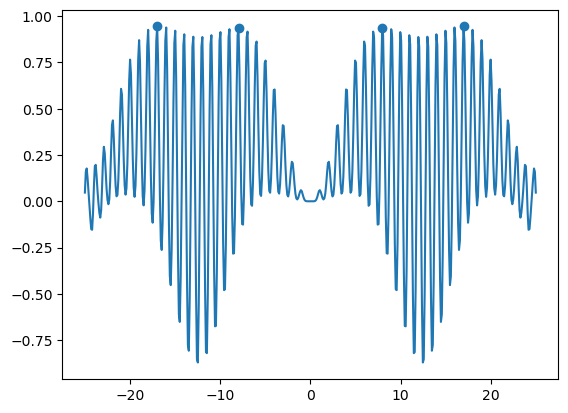

In [ ]:
t=90
dt=4
r = np.linspace(-25,25,500)
theta = np.radians(t)
x = r*np.cos(theta)
y = r*np.sin(theta)

X1,Y1 = Lattice(l=1,t0=0,N=N)
X2,Y2 = Lattice(l=1,t0=dt,N=N)
# X3,Y3 = Lattice(l=1,t0=10,N=10)

Z1 = GaussLattice(x,y,X1,Y1,s=0.2)
Z2 = GaussLattice(x,y,X2,Y2,s=0.2)
signal = Z1 - Z2
plt.plot(r,signal)

locs, _ = sp.signal.find_peaks(signal)
# plt.scatter(r[locs], signal[locs])
locs2, _ = sp.signal.find_peaks(signal[locs])
plt.scatter(r[locs][locs2], signal[locs][locs2])
print(r[locs][locs2])